In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from cbrain.imports import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DATA_DIR = '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/'
MEAN_DIR = '/home1/05488/tg847872/tmp/B020_purecrm_essv2_nonorm_sample1_noise1/'
REF_DIR = '/work/05488/tg847872/stampede2/ref/'

In [4]:
def global_mean(ds, var):
    return ds[var].mean(dim=('lat', 'lon', 'lev')) 

In [5]:
def plot_global_means(ds):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    axes[0].plot(global_mean(ds, 'TAP'))
    axes[1].plot(global_mean(ds, 'QAP'))
    plt.show()

In [6]:
def plot_time_lev(ds, var, func=np.mean, **kwargs):
    fig = plt.figure(figsize=(12, 5))
    plt.imshow(func(ds[var], axis=(2, 3)).T, **kwargs)
    plt.colorbar(shrink=0.3);
    plt.show()

In [7]:
def basics(debug, ref=False):
    if not ref: ds = xr.open_mfdataset(f'{DATA_DIR}*{debug}*', decode_times=False, decode_cf=False)
    else: ds = xr.open_mfdataset(f'{REF_DIR}AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-0[1-9]-00000.nc', 
                                 decode_times=False, decode_cf=False)
    plot_global_means(ds)
    plot_time_lev(ds, 'TAP', np.max)
    plot_time_lev(ds, 'QAP', np.max)
    return ds

In [8]:
def normalize(x, m, s):
    return (x - m[:, None, None]) / s[:, None, None]

In [9]:
def get_cb_inps(ds, t, m, s):
    x = np.concatenate(
        [ds['NNTC'][t], ds['NNQC'][t], ds['NNVC'][t], ds['dTdtadia'][t], ds['dQdtadia'][t],
         np.expand_dims(ds['NNPS'][t], 0), np.expand_dims(ds['NNSOLIN'][t], 0)]
    )
    return normalize(x, m, s)

In [24]:
def get_cb_inps_fp(ds, t, m, s):
    x = np.concatenate(
        [ds['NNTBP'][t], ds['NNQBP'][t], ds['NNVBP'][t], np.expand_dims(ds['NNPS'][t], 0),
         np.expand_dims(ds['NNSOLIN'][t], 0), np.expand_dims(ds['NNTS'][t], 0)]
    )
    return normalize(x, m, s)

In [11]:
def stack_outps(ds, t):
    x = np.concatenate(
        [ds['BRAINDQ'].isel(time=t)*L_V, ds['BRAINDT'].isel(time=t)*C_P, 
         ds['QRL'].isel(time=t)*C_P, ds['QRS'].isel(time=t)*C_P])
    return x

In [40]:
def stack_outps_fp(ds, t):
    x = np.concatenate(
        [ds['BRAINDT'].isel(time=t)*C_P, ds['BRAINDQ'].isel(time=t)*L_V])
    return x

## Debug runs cont.

### Reference run

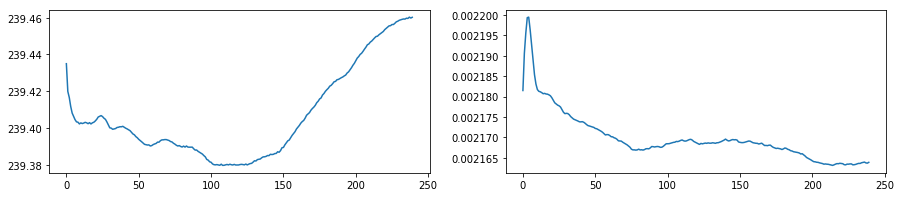

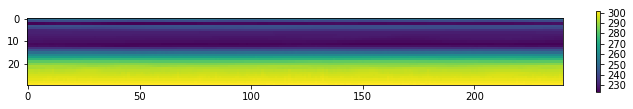

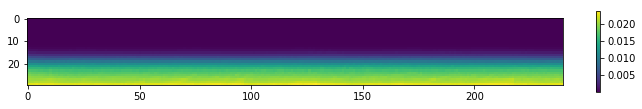

In [81]:
dref = basics('', True)

### Debug 38 - deep with medium l2 and tanh

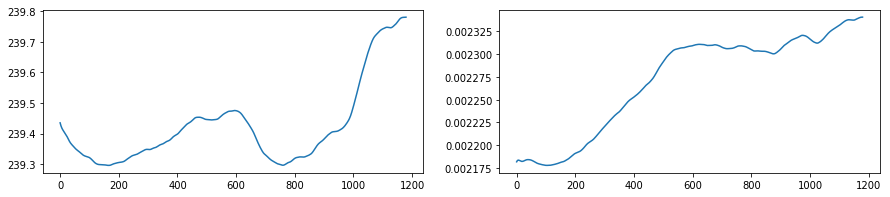

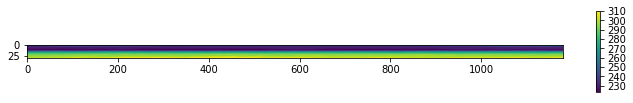

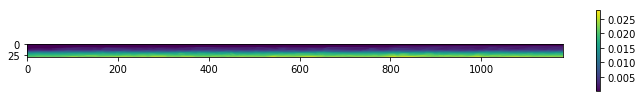

In [80]:
d38 = basics('debug38')

In [18]:
mean = np.loadtxt(
    '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/keras_matrices/inp_means.txt',
    delimiter=','
)

In [19]:
std = np.loadtxt(
    '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/keras_matrices/inp_max_rs.txt',
    delimiter=','
)

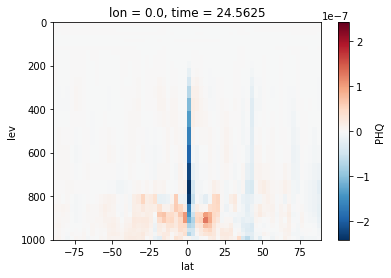

In [113]:
d38['PHQ'].isel(time=-1, lon=0).plot(yincrease=False);

In [96]:
DTbias = (d38['BRAINDT'].isel(time=range(0,240)).mean(dim=('time', 'lon')).values - 
          dref['SPDT'].isel(time=range(0,240)).mean(dim=('time', 'lon')).values)

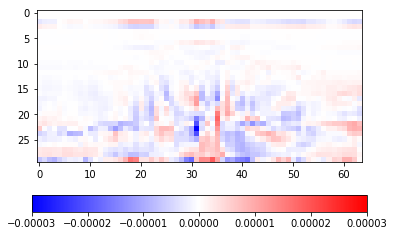

In [100]:
plt.imshow(DTbias, cmap='bwr', vmin=-3e-5, vmax=3e-5); plt.colorbar(orientation='horizontal');

In [101]:
DQbias = (d38['BRAINDQ'].isel(time=range(0,240)).mean(dim=('time', 'lon')).values - 
          dref['SPDQ'].isel(time=range(0,240)).mean(dim=('time', 'lon')).values)

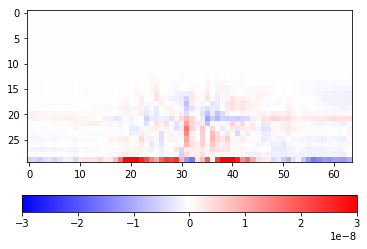

In [102]:
plt.imshow(DQbias, cmap='bwr', vmin=-3e-8, vmax=3e-8); plt.colorbar(orientation='horizontal');

In [103]:
Tbias = (d38['TAP'].isel(time=range(1,240)).mean(dim=('time', 'lon')).values - 
          dref['TAP'].isel(time=range(1,240)).mean(dim=('time', 'lon')).values)

In [79]:
plt.imshow(Tbias, cmap='bwr'); plt.colorbar(orientation='horizontal');

NameError: name 'Tbias' is not defined

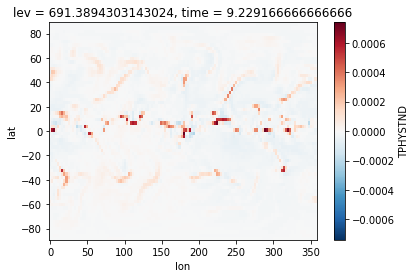

In [89]:
d38['TPHYSTND'].isel(time=-1, lev=-10).plot();

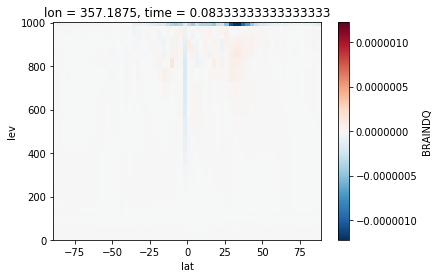

In [57]:
d38['BRAINDQ'].isel(time=-1, lon=-1).plot();

In [58]:
m38 = keras.models.load_model('/home1/05488/tg847872/tmp/B030_purecrm_essv2_nonorm_sample1_max_rs_deep_l2v2_tanh.h5')

In [59]:
inps = get_cb_inps(d38, 1, mean, std)

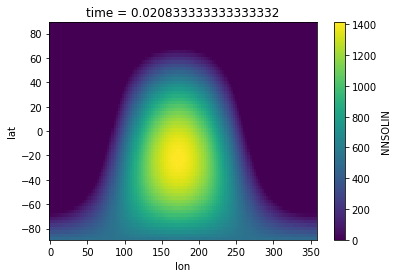

In [60]:
d38['NNSOLIN'][1].plot()

In [69]:
np.set_printoptions(linewidth=60)

In [71]:
inps[2:, 0, 0]

array([ 1.94242545e-01,  2.80301799e-01,  2.61007229e-01,
        3.38492197e-01,  3.48218351e-01,  3.91324255e-01,
        4.33549217e-01,  3.71539564e-01,  3.19142174e-01,
        2.77668299e-01,  1.71605820e-01,  2.43421239e-02,
       -1.35356537e-01, -2.31379898e-01, -2.64731911e-01,
       -2.96306611e-01, -3.06710761e-01, -2.72965552e-01,
       -2.96648536e-01, -2.89726477e-01, -2.73588248e-01,
       -2.91122729e-01, -3.10014428e-01, -3.00836448e-01,
       -3.09340388e-01, -3.25026584e-01, -3.01333322e-01,
       -2.87246386e-01,  2.16898748e-04,  2.28480179e-04,
        3.07020554e-04,  2.53223631e-04,  2.64420052e-04,
        2.30450632e-04,  1.85789260e-04,  1.52676847e-04,
        6.45914126e-05, -2.20656841e-04, -1.21271799e-03,
       -4.09323535e-03, -1.05324367e-02, -2.28386106e-02,
       -4.63153320e-02, -7.49632562e-02, -7.55081296e-02,
       -8.17324755e-02, -8.65783813e-02, -9.86446443e-02,
       -1.22691593e-01, -1.66267004e-01, -2.07742551e-01,
       -2.1633

In [62]:
preds = m38.predict(inps.reshape(152, -1).T).T.reshape(120, 64, 128); preds.shape

(120, 64, 128)

In [76]:
outps = stack_outps(d38, 1); outps.shape

(120, 64, 128)

In [77]:
preds[:, 0, 0]

array([-1.81338341e-31,  2.21915278e-31, -2.02765762e-07,
        1.55576828e-07, -2.47870702e-08, -2.66729323e-08,
       -1.31024606e-07, -3.97299630e-07, -1.25931501e-06,
        2.26495285e-06, -5.73291618e-06, -2.51553720e-05,
       -7.44592398e-07, -3.31550837e-06, -1.11147761e-04,
       -3.75721604e-04, -3.06718051e-04,  9.95248556e-05,
        9.87090170e-04,  2.49034166e-03,  4.67630476e-03,
        5.00069186e-03,  1.18959695e-03,  5.39123639e-03,
        1.65601855e-03, -4.32706065e-03, -4.30280343e-03,
       -5.25848940e-03, -2.93151475e-03, -9.91607904e-02,
       -2.94414503e-31,  2.61890361e-31, -1.96318813e-02,
        1.37620708e-02,  2.71882163e-06, -8.81490414e-05,
       -1.40774297e-04,  1.15298433e-04,  1.26969535e-05,
       -6.46803528e-05, -1.68233644e-04, -4.71646432e-04,
       -4.07714397e-05, -1.81926414e-04, -5.26010990e-05,
       -2.44200230e-04, -5.70729375e-04, -1.47910416e-03,
       -2.51133740e-03, -3.00335884e-03, -1.83741748e-03,
        1.0361

In [78]:
outps[:, 0, 0]

array([-1.81601252e-31,  2.22318590e-31, -2.02846664e-07,
        1.55639057e-07, -2.47969858e-08, -2.66836686e-08,
       -1.31077130e-07, -3.97458763e-07, -1.25982308e-06,
        2.26585030e-06, -5.73519856e-06, -2.51650272e-05,
       -7.43647831e-07, -3.30867465e-06, -1.11176218e-04,
       -3.75825271e-04, -3.06777220e-04,  9.96100571e-05,
        9.87550593e-04,  2.49132956e-03,  4.67814272e-03,
        5.00260200e-03,  1.19026529e-03,  5.39326854e-03,
        1.65655790e-03, -4.32871142e-03, -4.30443743e-03,
       -5.26073575e-03, -2.93290080e-03, -9.92005244e-02,
       -2.92853917e-31,  2.61067257e-31, -1.95411928e-02,
        1.36984978e-02,  2.70656801e-06, -8.77412385e-05,
       -1.40122982e-04,  1.14766219e-04,  1.26379509e-05,
       -6.43820822e-05, -1.67458857e-04, -4.69470397e-04,
       -4.05874671e-05, -1.81096577e-04, -5.23789677e-05,
       -2.43097311e-04, -5.68171323e-04, -1.47232052e-03,
       -2.49976316e-03, -2.98951427e-03, -1.82887970e-03,
        1.0314

### Debug 39 - first fullphy test with shallow net

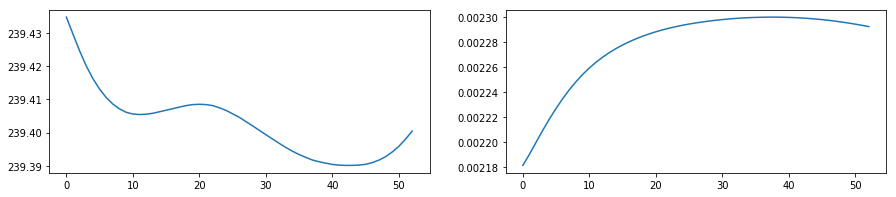

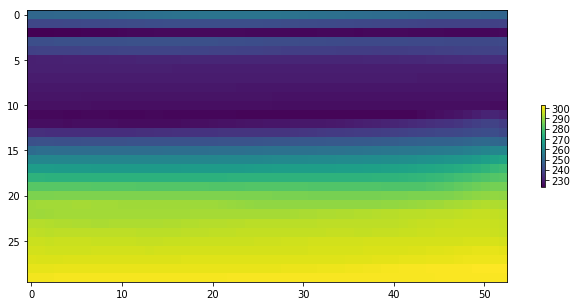

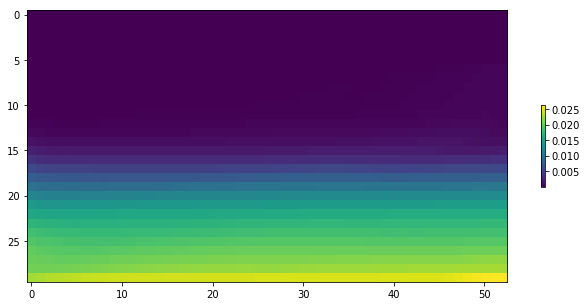

In [55]:
d39 = basics('debug39')

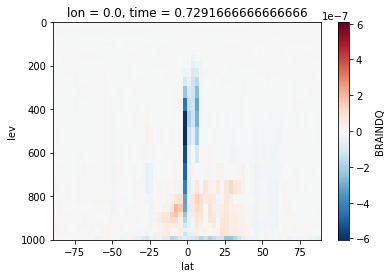

In [53]:
d39['BRAINDQ'].isel(time=-1, lon=0).plot(yincrease=False)

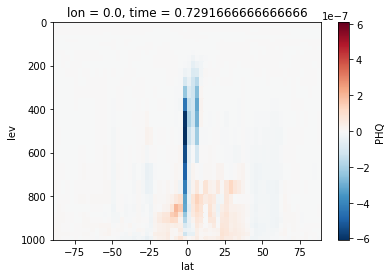

In [54]:
d39['PHQ'].isel(time=-1, lon=0).plot(yincrease=False)

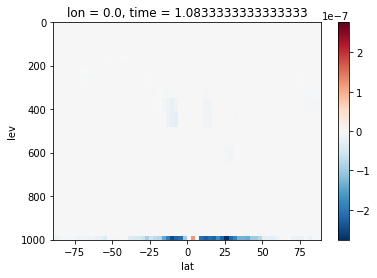

In [58]:
(d39['BRAINDQ'].isel(time=-1, lon=0)-d39['PHQ'].isel(time=-1, lon=0)).plot(yincrease=False)

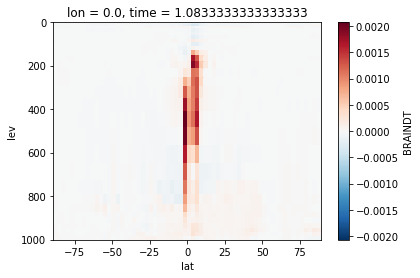

In [56]:
d39['BRAINDT'].isel(time=-1, lon=0).plot(yincrease=False)

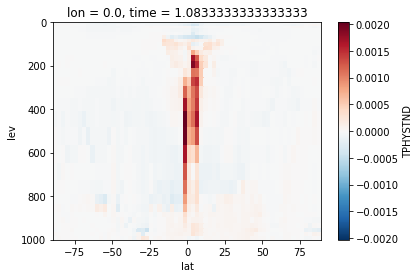

In [57]:
d39['TPHYSTND'].isel(time=-1, lon=0).plot(yincrease=False)

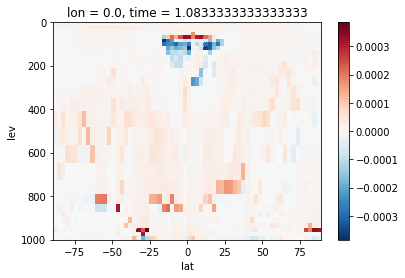

In [59]:
(d39['BRAINDT'].isel(time=-1, lon=0)-d39['TPHYSTND'].isel(time=-1, lon=0)).plot(yincrease=False)

#### Check inputs/outputs

In [27]:
mean = np.loadtxt(
    '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/keras_matrices/inp_means.txt',
    delimiter=','
)

In [28]:
std = np.loadtxt(
    '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/keras_matrices/inp_max_rs.txt',
    delimiter=','
)

In [29]:
inps = get_cb_inps_fp(d39, 1, mean, std)

In [30]:
inps[:,0,0]

array([ 2.48198762e-01,  1.81751186e-01,  1.99176272e-01,  2.89891689e-01,
        2.56080184e-01,  3.37891609e-01,  3.47478081e-01,  3.91534079e-01,
        4.33142151e-01,  3.66541357e-01,  3.25460427e-01,  2.66886552e-01,
        1.79750575e-01,  1.45477167e-02, -1.34198864e-01, -2.26101443e-01,
       -2.66107117e-01, -2.93624303e-01, -3.03345090e-01, -2.85141085e-01,
       -2.79928129e-01, -2.93494970e-01, -2.91343031e-01, -2.85562093e-01,
       -2.96730994e-01, -2.97725384e-01, -3.03419490e-01, -3.23828716e-01,
       -3.00074875e-01, -2.97259772e-01,  2.16278922e-04,  2.27713505e-04,
        3.05194646e-04,  2.52072580e-04,  2.63048571e-04,  2.29280639e-04,
        1.84732908e-04,  1.51843926e-04,  6.36291804e-05, -2.23726233e-04,
       -1.22574524e-03, -4.14605787e-03, -1.07062998e-02, -2.33079637e-02,
       -4.72026163e-02, -5.77001715e-02, -6.24617168e-02, -7.22319195e-02,
       -8.08580400e-02, -9.18018954e-02, -1.16538297e-01, -1.59057216e-01,
       -2.00891325e-01, -

In [31]:
m39 = keras.models.load_model('/home1/05488/tg847872/tmp/A002_fullphy_essv2_nonorm_sample1_max_rs.h5')

In [33]:
preds = m39.predict(inps.reshape(93, -1).T).T.reshape(60, 64, 128); preds.shape

(60, 64, 128)

In [41]:
outps = stack_outps_fp(d39, 1); outps.shape

(60, 64, 128)

In [35]:
preds[:,0,0]

array([-3.5691750e-03, -2.5337404e-03, -1.6460530e-03,  1.0970794e-03,
       -1.6922550e-03, -4.6304404e-04, -3.7860870e-04, -6.5556914e-04,
       -1.0224597e-03, -2.0534731e-04, -1.1500437e-03,  9.1178715e-04,
       -4.1539222e-04, -1.8268079e-03, -1.3749599e-03, -3.7352070e-03,
       -5.8781467e-03, -9.2432760e-03, -8.6252354e-03, -5.8380757e-03,
       -4.5580976e-03, -4.1164644e-03, -6.5657124e-04, -9.0748612e-03,
        1.3058502e-02,  1.5878987e-02,  1.0000639e-02, -5.2019954e-05,
       -1.1322685e-02, -2.6551189e-02, -1.7730839e-10,  5.0726767e-10,
       -3.1871195e-07, -3.8585313e-09,  1.0161273e-08,  1.0623384e-07,
       -6.0357456e-07,  1.8229002e-07,  1.6083504e-06, -1.2944220e-06,
        5.0038332e-05,  5.3189695e-05, -4.3706037e-05,  6.0070306e-06,
       -3.7257373e-04, -1.0090321e-04, -5.1870942e-04,  1.3887398e-03,
        2.3578079e-03,  1.7296933e-03, -1.8351153e-04, -1.9032713e-03,
       -2.4616793e-03,  1.2793794e-02,  5.0182566e-03,  1.7906367e-03,
      

In [42]:
outps[:,0,0]

array([-3.5526955e-03, -2.5220707e-03, -1.6381574e-03,  1.0917984e-03,
       -1.6844334e-03, -4.6090040e-04, -3.7685008e-04, -6.5252319e-04,
       -1.0178108e-03, -2.0438472e-04, -1.1447230e-03,  9.0757554e-04,
       -4.1345184e-04, -1.8183563e-03, -1.3688043e-03, -3.7178216e-03,
       -5.8509940e-03, -9.2008393e-03, -8.5855732e-03, -5.8111153e-03,
       -4.5367745e-03, -4.0971301e-03, -6.5341755e-04, -9.0333186e-03,
        1.2998291e-02,  1.5806127e-02,  9.9548940e-03, -5.1750398e-05,
       -1.1270767e-02, -2.6429037e-02, -1.7737593e-10,  5.0748533e-10,
       -3.1884110e-07, -3.8584043e-09,  1.0167039e-08,  1.0627788e-07,
       -6.0382052e-07,  1.8235069e-07,  1.6090823e-06, -1.2949371e-06,
        5.0062041e-05,  5.3218377e-05, -4.3710348e-05,  6.0464299e-06,
       -3.7264847e-04, -1.0081737e-04, -5.1891012e-04,  1.3895814e-03,
        2.3587407e-03,  1.7303647e-03, -1.8381620e-04, -1.9042362e-03,
       -2.4631568e-03,  1.2798395e-02,  5.0210678e-03,  1.7921426e-03,
      

### Debug 40 - new setting to zero of tends

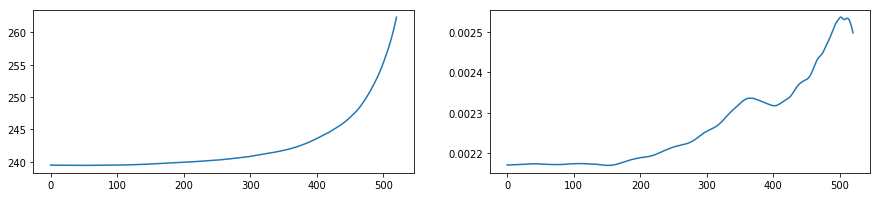

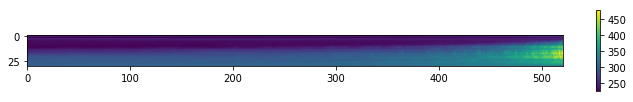

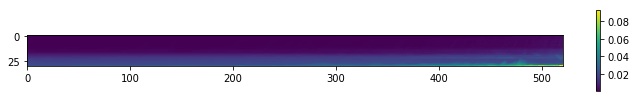

In [83]:
d40 = basics('debug40')

In [ ]:
d40['QAP'].isel(time=-1, lev=-1).plot()

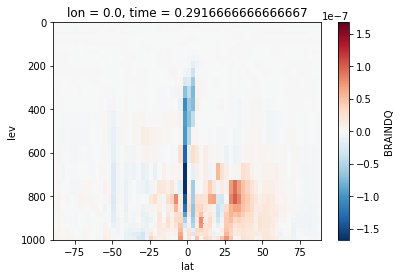

In [62]:
d40['BRAINDQ'].isel(time=-1, lon=0).plot(yincrease=False)

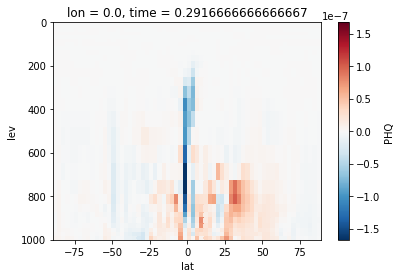

In [63]:
d40['PHQ'].isel(time=-1, lon=0).plot(yincrease=False)

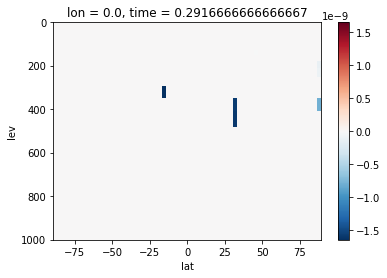

In [64]:
(d40['BRAINDQ'].isel(time=-1, lon=0)-d40['PHQ'].isel(time=-1, lon=0)).plot(yincrease=False)

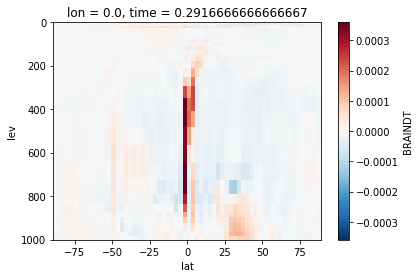

In [65]:
d40['BRAINDT'].isel(time=-1, lon=0).plot(yincrease=False)

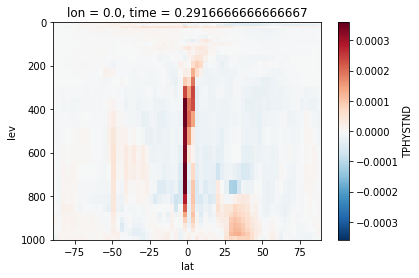

In [66]:
d40['TPHYSTND'].isel(time=-1, lon=0).plot(yincrease=False)

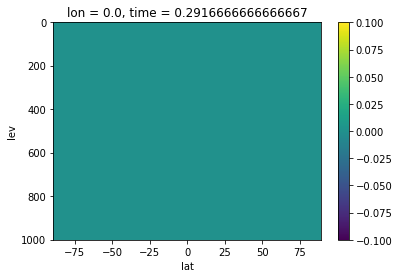

In [67]:
(d40['BRAINDT'].isel(time=-1, lon=0)-d40['TPHYSTND'].isel(time=-1, lon=0)).plot(yincrease=False)